In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np 
from numpy import log
import gmaps 
import gmaps.datasets 
import matplotlib.pyplot as plt
from datetime import datetime
plt.style.use('ggplot')
from sorted_months_weekdays import Month_Sorted_Month
from statsmodels.tsa.stattools import adfuller

from statsmodels.tools.data import _is_using_pandas
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.statespace.kalman_filter import MEMORY_CONSERVE
from statsmodels.tsa.statespace.tools import diff
import statsmodels.base.wrapper as wrap
import statsmodels.api
import statsmodels as sm
import statsmodels.api as sm

In [4]:
# read in electricity consumption data
electricity_df = pd.read_csv('data/GRU_Customer_Electric_Consumption.csv')

In [5]:
# read in population data for the city of Gainesville
population_df = pd.read_csv('./data/population.csv')
pd.set_option('display.max_rows', 500)

In [6]:
# Set Date column as index in population dataframe
population_df.set_index('Date')
pd.set_option('display.max_rows', 500)

In [8]:
# Convert dates into datetime format
electricity_df['Date'] = pd.to_datetime(electricity_df['Date'])

In [9]:
# Groupby date of electrical consumption and aggregate values by mean for each date

grouped_e_df = electricity_df.groupby('Date', dropna=True, sort=True).mean()
pd.set_option('display.max_rows', 500)

In [10]:
# join the popluation dataframe with the average monthly dataframe
pop_e_df = grouped_e_df.join(population_df.set_index('Date'), how='left', lsuffix='_left', rsuffix='_right')
pop_e_df = pop_e_df.drop('Year_right', axis=1)
pop_e_df = pop_e_df.rename(columns={'Year_left': 'Year'})

In [11]:
# add column with electricity use per capita 
pop_e_df['avg_kwh_capita'] = pop_e_df['KWH Consumption'] / pop_e_df['Population']
pop_e_df.describe()

,Year,KWH Consumption,Latitude,Longitude,Population,avg_kwh_capita
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
mean,2015.924528,1641.960719,29.655229,-82.371267,130890.518868,0.012531
std,2.558638,468.249083,0.000311,0.005510,2934.605677,0.003458
min,2012.000000,1034.577927,29.654105,-82.375649,126038.000000,0.008053
25%,2014.000000,1355.114259,29.655034,-82.372416,128474.000000,0.010376
50%,2016.000000,1479.596557,29.655238,-82.371858,131593.000000,0.011380
75%,2018.000000,1817.771524,29.655371,-82.371624,133851.000000,0.013979
max,2020.000000,3909.588921,29.656450,-82.339323,134945.000000,0.028972


Text(0.5, 1.0, 'Gainesville, FL KWH per Capita 2012-2020')

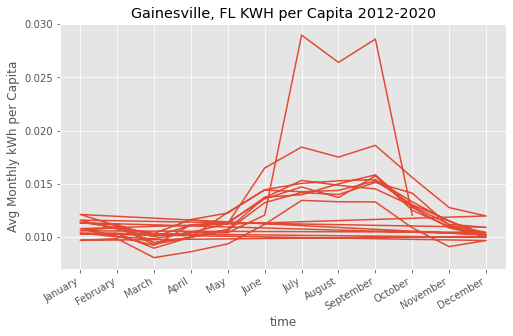

In [12]:
# Plot annual electrical consumption for all years

x = pop_e_df['Month']
y = pop_e_df['avg_kwh_capita']

# ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

fig, ax = plt.subplots(figsize=(8, 5))
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right', which='major')
plt.plot(x, y)
ax.set_xlabel('time')
ax.set_ylabel('Avg Monthly kWh per Capita')
ax.set_title('Gainesville, FL KWH per Capita 2012-2020')

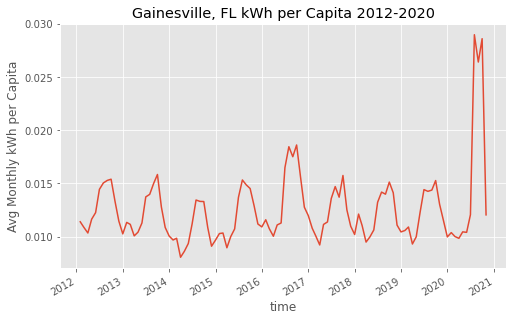

In [13]:
# plot historical consumption for years in sequence 

x = pop_e_df.index
y = pop_e_df['avg_kwh_capita']

fig, ax = plt.subplots(figsize=(8, 5))
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right', which='major')
plt.plot(x, y)
ax.set_xlabel('time')
ax.set_ylabel('Avg Monthly kWh per Capita')
ax.set_title('Gainesville, FL kWh per Capita 2012-2020')
plt.savefig('images/kWh_per_capita.png')

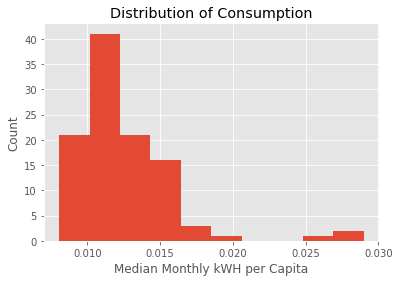

In [14]:
# Checking for stationarity by Summary Statistics

pop_e_df['avg_kwh_capita'].hist()
plt.xlabel('Median Monthly kWH per Capita')
plt.ylabel('Count')
plt.title('Distribution of Consumption')
plt.savefig('images/med_count_hist.png')

In [15]:
# calculate summary statistics for above median consumption for stationarity

series = pop_e_df['avg_kwh_capita']
X = series.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=0.011750, mean2=0.013313
variance1=0.000004, variance2=0.000018


In [16]:
# ADF test with full set of observations for stationarity

series = pop_e_df['avg_kwh_capita']
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.440568
p-value: 0.562681
Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584


In [17]:
#remove COVID dates
data_start,cov_start = '2012-01-31','2020-01-31'
cov_rem = pop_e_df['avg_kwh_capita'][data_start:cov_start]
len(cov_rem)

97

In [18]:
# ADF test with COVID observations removed

series = cov_rem
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.110337
p-value: 0.240378
Critical Values:
	1%: -3.511
	5%: -2.897
	10%: -2.585


In [19]:
# log transform and ADF test to better reflect the expectations of the statistical test
series = cov_rem
X = series.values
X = log(X)
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.993688
p-value: 0.289347
	1%: -3.511
	5%: -2.897
	10%: -2.585


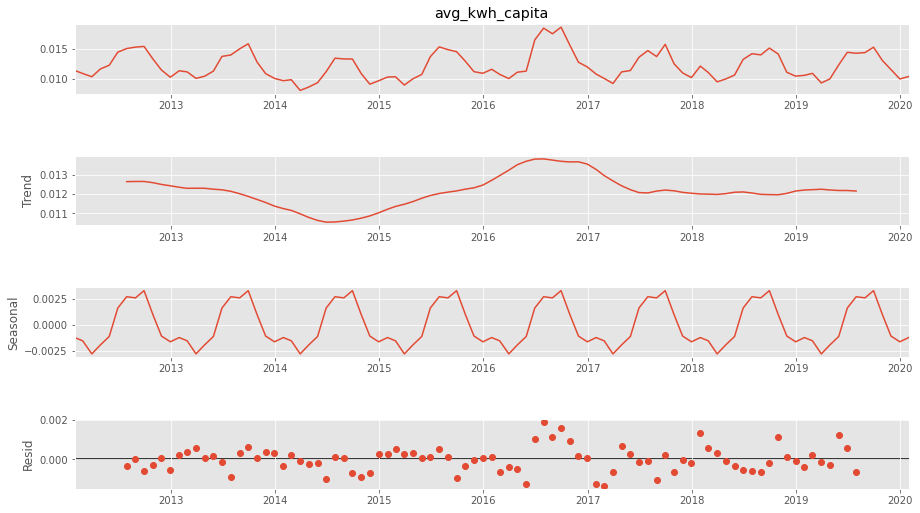

In [20]:
# show seasonal decomposition of consumption with COVID removed

res = sm.tsa.seasonal_decompose(cov_rem,period=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.savefig('images/seas_decomp.png')

In [21]:
diffed = cov_rem.diff().dropna()

In [22]:
#ADF-test with diffed data with c regression order for data stationary
res = sm.tsa.adfuller(cov_rem.diff().dropna(),regression='c')
print('p-value:{}'.format(res[1]))

p-value:0.03972232841202335


In [23]:
#ADF-test with diffed data with ctt regression order for data stationary
res = sm.tsa.adfuller(cov_rem.diff().dropna(),regression='ctt')
print('p-value:{}'.format(res[1]))

p-value:0.2739869578643366


In [24]:
# ADF test of diffed consumption data with COVID dates removed
res = sm.tsa.adfuller(diffed)
print('p-value:{}'.format(res[1]))

p-value:0.03972232841202335


In [27]:
# ADF test of non diffed consumption data with COVID dates removed
res = sm.tsa.adfuller(cov_rem.dropna(), regression='c')
print('p-value:{}'.format(res[1]))

p-value:0.24037827106030185


In [ ]:
# export diffed and not diffed data for training in another notebook
diffed.to_csv(r'diffed_data.csv', header=True)
cov_rem.to_csv(r'not_diffed.csv', header=True)